In [1]:
import os
import time
import argparse
import datetime
import numpy as np

import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.cuda.amp as amp

from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from timm.utils import accuracy, AverageMeter

from config import get_config
from models import build_model
from data import build_loader
from optimizer import build_optimizer
from logger import create_logger
from utils import load_checkpoint, load_pretrained, save_checkpoint, get_grad_norm, auto_resume_helper, reduce_tensor

from contextlib import nullcontext
from torch.utils.tensorboard import SummaryWriter
from timm.data.transforms import _pil_interp
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, DistributedSampler
from data.data_dmim import *
from einops import rearrange
from PIL import Image
from torchvision.utils import make_grid
import matplotlib as plt

class sampleTransform(dmimTransform):
    def __init__(self, config):
        super().__init__(config)
        self.eval_transform = transforms.Compose([transforms.Resize((config.DATA.IMG_SIZE, config.DATA.IMG_SIZE),
                                                                    interpolation=_pil_interp(config.DATA.INTERPOLATION)),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)])
    
    def __call__(self, img):
        augmented_pair = self.aug_pair_transform(img)
        img = self.eval_transform(img)
        mask = self.mask_generator()
        
        return img, mask, augmented_pair
class argslike():
    def __init__(self):
        pass
def collate_fn(batch):
    if not isinstance(batch[0][0], tuple):
        return default_collate(batch)
    else:
        batch_num = len(batch)
        ret = []
        for item_idx in range(len(batch[0][0])):
            if batch[0][0][item_idx] is None:
                ret.append(None)
            else:
                ret.append(default_collate([batch[i][0][item_idx] for i in range(batch_num)]))
        ret.append(default_collate([batch[i][1] for i in range(batch_num)]))
        return ret
def show_img(imgs, nrow = 1):
    IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
    IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)
    
    mean=torch.tensor(IMAGENET_DEFAULT_MEAN).cuda(non_blocking=True).unsqueeze(1).unsqueeze(2)
    std=torch.tensor(IMAGENET_DEFAULT_STD).cuda(non_blocking=True).unsqueeze(1).unsqueeze(2)
    
    all_figs = [x.mul_(std).add_(mean).clamp_(0., 1.) for x in imgs]
    
    grid = torch.stack(all_figs, 0)
    #grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=nrow)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
    img_to_save = Image.fromarray(grid.astype(np.uint8), mode="RGB")
    display(img_to_save)

/mnt/urchin/kzou/ana/envs/py39torch19/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = argslike()
args.cfg = './configs/vit_base_ldm/dmim_pretrain__vit_base_ldm__img192__100ep.yaml'
args.opts = None
args.local_rank = 0
args.output = './output_visualize'
args.batch_size = 10

config = get_config(args)
dataset = datasets.ImageFolder(
    '/mnt/urchin/kzou/data/ILSVRC/Data/CLS-LOC/val', 
    transform=sampleTransform(config)
)
dataloader = DataLoader(dataset, config.DATA.BATCH_SIZE, collate_fn=collate_fn)
model = build_model(config, is_pretrain=True)
model.cuda()

=> merge config from ./configs/vit_base_ldm/dmim_pretrain__vit_base_ldm__img192__100ep.yaml


/mnt/urchin/kzou/ana/envs/py39torch19/lib/python3.9/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


dmimWithLDM(
  (encoder): VisionTransformerFordmimWithLDM(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rel_pos_bias): RelativePositionBias()
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )

In [3]:
print(f">>>>>>>>>> Resuming from {config.MODEL.RESUME} ..........")
resume = '/mnt/urchin/kzou/code/transformer/output_pt_ldm_constrastive/output_pt_ldm_192_ep800_unet_contrastive_loss/dmim_pretrain/dmim_pretrain__vit_base__img192__100ep/ckpt_epoch_100.pth'
resume = '/mnt/urchin/kzou/code/transformer/output_pt_ldm_x0/output_pt_ldm_192_ep800_x0_bs1024/dmim_pretrain/dmim_pretrain__vit_base__img192__100ep/ckpt_epoch_520.pth'
resume = '/mnt/urchin/kzou/code/transformer/output_pt_ldm_constrastive/output_pt_ldm_192_ep800_0.5contrastive_loss_32/dmim_pretrain/dmim_pretrain__vit_base__img192__100ep/ckpt_epoch_100.pth'
checkpoint = torch.load(resume, map_location='cpu')
# re-map keys due to name change (only for loading provided models)
rpe_mlp_keys = [k for k in checkpoint['model'].keys() if "rpe_mlp" in k]
for k in rpe_mlp_keys:
    checkpoint['model'][k.replace('rpe_mlp', 'cpb_mlp')] = checkpoint['model'].pop(k)

msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)
del checkpoint
torch.cuda.empty_cache()

>>>>>>>>>> Resuming from  ..........
<All keys matched successfully>


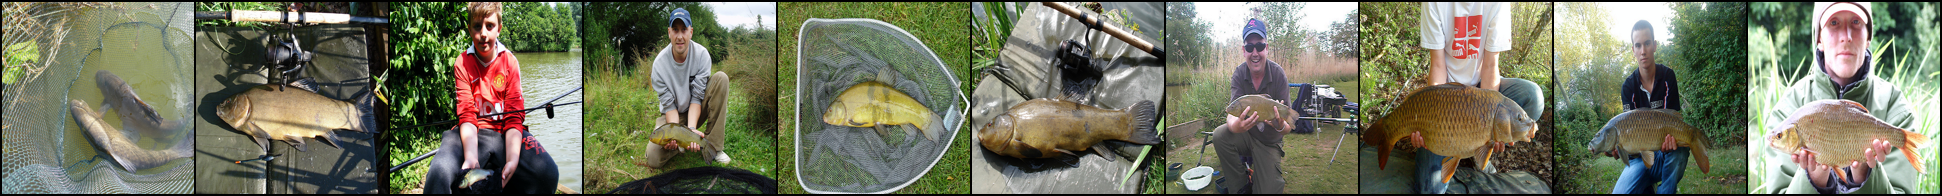

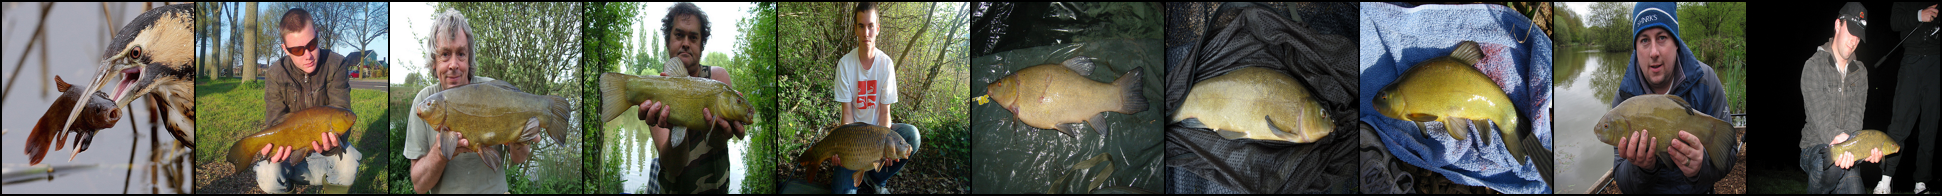

In [4]:
max_iter = 1
for idx, (img, mask, augmented_pair, _) in enumerate(dataloader):
    #print(len(t),len(t[0]),t[1].shape)
    img = img.cuda(non_blocking=True)
    mask = mask.cuda(non_blocking=True)
    augmented_pair = [aug.cuda(non_blocking=True) for aug in augmented_pair]
    z1, z2 = (torch.nn.functional.normalize(model.encoder(aug, None).flatten(1), dim=1) for aug in augmented_pair)
    show_img([x for x in img], img.shape[0])
    if idx == max_iter:
        break

/tmp/ipykernel_2026349/3053845520.py:7: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img_to_save = Image.fromarray(np.array(t).astype(np.uint8), mode="L").resize((256,256), Image.NEAREST)


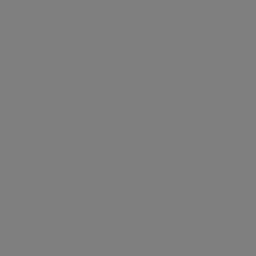

In [5]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
def cos_sim(z1, z2):
    return (1 - (z1 * z2).sum(dim=-1))
t = [[float(cos_sim(x1, x2) + 1) / 2. * 255 for x2 in z2] for x1 in z1]
img_to_save = Image.fromarray(np.array(t).astype(np.uint8), mode="L").resize((256,256), Image.NEAREST)
root = '/mnt/urchin/kzou/code/transformer/output_sample/dmim_pretrain/dmim_pretrain__vit_base__img192__100ep'
img_to_save.save(os.path.join(root, 'test.png'), quality=95)
img_to_save

/tmp/ipykernel_2026349/1221661883.py:3: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img_to_save = Image.fromarray(np.array(t).astype(np.uint8), mode="L").resize((256,256), Image.NEAREST)


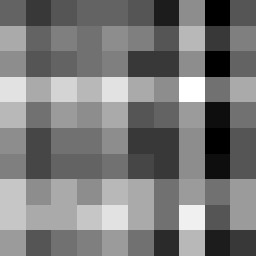

In [11]:
c = np.array([[float(cos_sim(x1, x2)) for x2 in z2] for x1 in z1])
t = [[(a - c.min())/(c.max()-c.min())*255 for a in b] for b in c]
img_to_save = Image.fromarray(np.array(t).astype(np.uint8), mode="L").resize((256,256), Image.NEAREST)
root = '/mnt/urchin/kzou/code/transformer/output_sample/dmim_pretrain/dmim_pretrain__vit_base__img192__100ep'
img_to_save.save(os.path.join(root, '0.5contrast_rel.png'), quality=95)
img_to_save

In [12]:
c

array([[5.36441803e-07, 3.57627869e-07, 4.76837158e-07, 5.36441803e-07,
        5.36441803e-07, 4.76837158e-07, 2.38418579e-07, 7.15255737e-07,
        1.19209290e-07, 4.76837158e-07],
       [8.34465027e-07, 5.36441803e-07, 6.55651093e-07, 5.96046448e-07,
        7.15255737e-07, 6.55651093e-07, 4.76837158e-07, 8.94069672e-07,
        3.57627869e-07, 6.55651093e-07],
       [7.15255737e-07, 4.76837158e-07, 5.36441803e-07, 5.96046448e-07,
        6.55651093e-07, 3.57627869e-07, 3.57627869e-07, 7.15255737e-07,
        1.19209290e-07, 5.36441803e-07],
       [1.07288361e-06, 8.34465027e-07, 1.01327896e-06, 8.94069672e-07,
        1.07288361e-06, 8.34465027e-07, 7.15255737e-07, 1.19209290e-06,
        5.96046448e-07, 8.34465027e-07],
       [8.94069672e-07, 5.96046448e-07, 7.74860382e-07, 7.15255737e-07,
        8.34465027e-07, 4.76837158e-07, 5.36441803e-07, 7.74860382e-07,
        1.78813934e-07, 5.96046448e-07],
       [7.15255737e-07, 4.17232513e-07, 5.96046448e-07, 5.96046448e-07,
   

In [6]:
t

[[127.50006079673767,
  127.50004559755325,
  127.50006079673767,
  127.50006079673767,
  127.50006079673767,
  127.50006079673767,
  127.50003039836884,
  127.5000911951065,
  127.50001519918442,
  127.50006079673767],
 [127.50010639429092,
  127.50006079673767,
  127.5000911951065,
  127.50007599592209,
  127.5000911951065,
  127.5000911951065,
  127.50006079673767,
  127.50012159347534,
  127.50004559755325,
  127.5000911951065],
 [127.5000911951065,
  127.50006079673767,
  127.50006079673767,
  127.50007599592209,
  127.5000911951065,
  127.50004559755325,
  127.50004559755325,
  127.5000911951065,
  127.50001519918442,
  127.50006079673767],
 [127.50013679265976,
  127.50010639429092,
  127.50012159347534,
  127.50012159347534,
  127.50013679265976,
  127.50010639429092,
  127.5000911951065,
  127.50015199184418,
  127.50007599592209,
  127.50010639429092],
 [127.50012159347534,
  127.50007599592209,
  127.5000911951065,
  127.5000911951065,
  127.50010639429092,
  127.50006079673

In [11]:
t

[[188.51843297481537,
  195.94712555408478,
  209.0809080004692,
  184.61440086364746,
  202.79235184192657,
  188.24527323246002,
  178.88070613145828,
  184.53515231609344,
  197.21674382686615,
  181.4346706867218],
 [199.02593314647675,
  199.28703993558884,
  207.10898101329803,
  184.82372403144836,
  209.93119597434998,
  194.11098808050156,
  194.06853675842285,
  202.39794820547104,
  190.22180557250977,
  180.33274501562119],
 [213.40089619159698,
  208.41842114925385,
  213.14413636922836,
  210.1582109928131,
  219.43442523479462,
  216.29962384700775,
  214.2035499215126,
  211.51306629180908,
  215.76657325029373,
  214.00457739830017],
 [202.37952679395676,
  204.43901628255844,
  210.02950429916382,
  210.4357025027275,
  212.64511674642563,
  215.98224967718124,
  204.55301016569138,
  208.77037346363068,
  205.5607920885086,
  208.48590552806854],
 [213.14968407154083,
  216.69825285673141,
  218.7965914607048,
  221.77789628505707,
  218.44985246658325,
  227.1987766

In [7]:
t

[[223.52884232997894,
  221.697735786438,
  220.5728441476822,
  221.04265093803406,
  224.38697308301926,
  224.0685197710991,
  220.02281606197357,
  223.84272068738937,
  221.84401273727417,
  226.5725702047348],
 [224.3121474981308,
  221.55963599681854,
  218.22937309741974,
  222.22016215324402,
  225.2675074338913,
  226.8028074502945,
  221.64385467767715,
  227.62605607509613,
  224.76386725902557,
  221.09578728675842],
 [221.6371974349022,
  226.92473530769348,
  218.489248752594,
  219.3271341919899,
  226.36853635311127,
  220.49709141254425,
  215.78218281269073,
  223.82729351520538,
  227.32842564582825,
  224.64926540851593],
 [221.83206617832184,
  225.69022715091705,
  223.88105303049088,
  220.02992928028107,
  226.94529980421066,
  221.20239436626434,
  218.66125792264938,
  228.33342611789703,
  221.53016477823257,
  228.669556081295],
 [222.3696917295456,
  221.82721763849258,
  225.1706886291504,
  223.72485101222992,
  227.70250797271729,
  222.98992484807968,
